In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
%matplotlib inline

Writing xzh20190441125.py


In [2]:
train = pd.read_json("D:/software/statoil-iceberg-classifier-challenge/train.json")

In [3]:
def standardise_data(data):
    '''standardise vector'''
    out = (np.array(data) - np.mean(data)) / np.std(data)
    return out.tolist()

def process1_data(data, predict=False):
    data["band_1"] = data["band_1"].apply(standardise_data)
    data["band_2"] = data["band_2"].apply(standardise_data)
    #将一维数据转换为75，75的二维数据
    band1 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in data["band_1"]])
    band2 = np.array([np.array(band).astype(np.float32).reshape(75,75) for band in data["band_2"]])
    #增加维度后将扩充的数据与原数据进行拼接
    X = np.concatenate([band1[:, :, :, np.newaxis], 
                            band2[:, :, :, np.newaxis],
                            ((band1+band2)/2)[:, :, :, np.newaxis]], 
                            axis=-1)
    if predict==False:
        y = np.array(data['is_iceberg'])
        return X, y
    return X


In [4]:
def create_more_data(images):
    #通过旋转、翻转扩充数据
    image_rot90 = []
    image_rot180 = []
    image_rot270 = []
    img_lr = []
    img_ud = []
    for i in range(0,images.shape[0]):
        band_1 = images[i,:,:,0]
        band_2 = images[i,:,:,1]
        band_3 = images[i,:,:,2]
        
        #旋转90度
        band_1_rot90 = np.rot90(band_1)
        band_2_rot90 = np.rot90(band_2)
        band_3_rot90 = np.rot90(band_3)
        image_rot90.append(np.dstack((band_1_rot90,
                            band_2_rot90,band_3_rot90)))
        
        #旋转180度
        band_1_rot180 = np.rot90(band_1_rot90)
        band_2_rot180 = np.rot90(band_2_rot90)
        band_3_rot180 = np.rot90(band_3_rot90)
        image_rot180.append(np.dstack((band_1_rot180,
                            band_2_rot180,band_3_rot180)))
        
        #旋转270度
        band_1_rot270 = np.rot90(band_1_rot180)
        band_2_rot270 = np.rot90(band_2_rot180)
        band_3_rot270 = np.rot90(band_3_rot180)
        image_rot270.append(np.dstack((band_1_rot270,
                            band_2_rot270,band_3_rot270)))
        
        #左右翻转
        lr1 = np.flip(band_1,0)
        lr2 = np.flip(band_2,0)
        lr3 = np.flip(band_3,0)
        img_lr.append(np.dstack((lr1,lr2,lr3)))
        
        #上下翻转
        ud1 = np.flip(band_1,1)
        ud2 = np.flip(band_2,1)
        ud3 = np.flip(band_3,1)
        img_ud.append(np.dstack((ud1,ud2,ud3)))
        
    rot90 = np.array(image_rot90)
    rot180 = np.array(image_rot180)
    rot270 = np.array(image_rot270)
    lr = np.array(img_lr)
    ud = np.array(img_ud)
    images = np.concatenate((images,rot90,rot180,rot270,lr,ud))
    return images

In [5]:
def process_data(data_frame,more_data):
    #获取图像数据
    images =[]
    for _,row in data_frame.iterrows():
        #将以为数据转换为75，75的二维数据
        band_1 = np.array(row['band_1']).reshape(75,75)
        band_2 = np.array(row['band_2']).reshape(75,75)
        band_3 = band_1+band_2
        images.append(np.dstack((band_1,band_2,band_3)))
        
    if more_data:
        #扩充数据集
        images = create_more_data(np.array(images))
    else :
        images = create_more_data(np.array(images))
        return np.array(images)
    #获取类标
    labels = np.array(data_frame['is_iceberg'])
    if more_data:
        #扩充数据集后，类标也需要相应扩充
        labels = np.concatenate((labels,labels,labels,labels,labels,labels))
    
    return np.array(images),labels


In [6]:
X_train, y_train = process1_data(train)

0


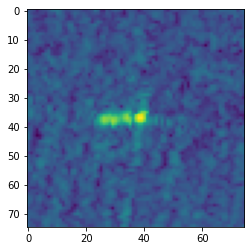

In [7]:
plt.imshow(X_train[80,:,:,0])
print(y_train[80])

1


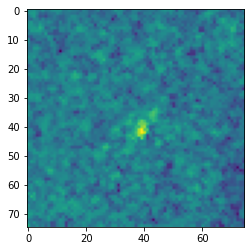

In [8]:
plt.imshow(X_train[91,:,:,0])
print(y_train[91])

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation, BatchNormalization
from keras.optimizers import adam_v2
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping
from tensorflow.keras import layers

In [10]:
def getModel():
    #建立一个序贯模型
    model = tf.keras.Sequential()
    #第一个卷积块
    model.add(layers.Conv2D(128,kernel_size=(3,3),activation = 'relu',
            input_shape=(75,75,3)))
    model.add(layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    model.add(layers.Dropout(0.2))
    #第二个卷积块
    model.add(layers.Conv2D(128,kernel_size=(3,3),activation = 'relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(layers.Dropout(0.2))
    #第三个卷积块
    model.add(layers.Conv2D(64,kernel_size=(2,2),activation = 'relu'))
    model.add(layers.MaxPooling2D(pool_size=(3,3),strides=(2,2)))
    model.add(layers.Dropout(0.2))
    #第四个卷积块
    model.add(layers.Conv2D(64,kernel_size=(2,2),activation = 'relu'))
    model.add(layers.MaxPooling2D(pool_size=(2,2),strides=(2,2)))
    model.add(layers.Dropout(0.2))
    #将上一层的输出特征映射转换为一维数据，
    #以便进行全连接操作
    model.add(layers.Flatten())
    #第一个全连接层
    model.add(layers.Dense(256))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.2))
    #第二个全连接层
    model.add(layers.Dense(128))
    model.add(layers.Activation('relu'))
    model.add(layers.Dropout(0.2))
    #第三个全连接层
    model.add(layers.Dense(1))
    model.add(layers.Activation('sigmoid'))
    #编译模型
    mypotim=adam_v2.Adam(lr=0.0008, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0, amsgrad=True)
    model.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    model.summary()
    return model

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min")
    msave = ModelCheckpoint(filepath, save_best_only=True)
    return [es, msave]
file_path = "model_weights3.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)

In [11]:
X_train_cv, X_valid, y_train_cv, y_valid = train_test_split(X_train, y_train, random_state=1, test_size=0.25)

In [12]:
gen = ImageDataGenerator(rotation_range=10, width_shift_range=0.3, height_shift_range=0.3, 
                         zoom_range=0.2, horizontal_flip=True, vertical_flip=True)
gen.fit(X_train_cv)

In [13]:
gmodel=getModel()

history = gmodel.fit(gen.flow(X_train_cv, y_train_cv, batch_size=32),steps_per_epoch=38,
                    epochs=50, verbose=1, validation_data=(X_valid, y_valid), callbacks=callbacks)

D:\python\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 73, 73, 128)       3584      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 36, 36, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 36, 36, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 34, 34, 128)       147584    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 17, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 17, 17, 128)       0

In [14]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

13/13 [==============================] - 1s 86ms/step - loss: 0.2520 - accuracy: 0.9027
Test loss: 0.2519703209400177
Test accuracy: 0.9027431607246399


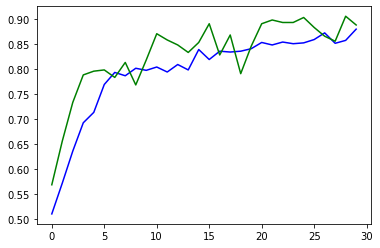

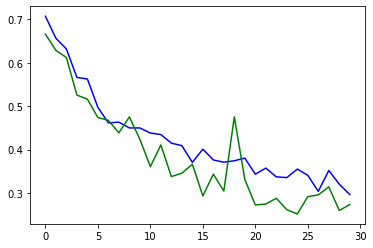

In [15]:
plt.plot(history.epoch, history.history['accuracy'], 'b',history.epoch, history.history['val_accuracy'], 'g')
plt.show()
plt.plot(history.epoch, history.history['loss'], 'b',history.epoch, history.history['val_loss'], 'g')
plt.show()

real: 1 predicted: [0.]


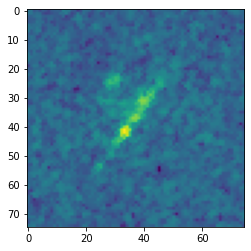

real: 0 predicted: [1.]


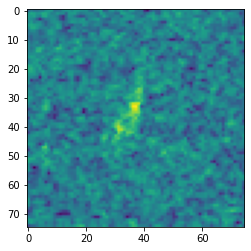

real: 1 predicted: [0.]


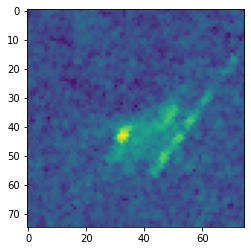

real: 0 predicted: [1.]


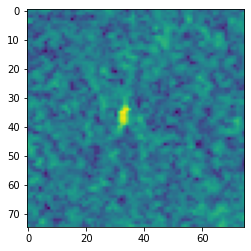

real: 1 predicted: [0.]


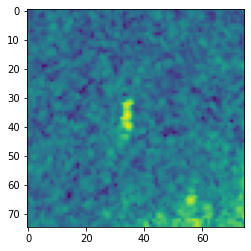

real: 1 predicted: [0.]


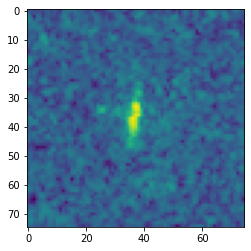

real: 1 predicted: [0.]


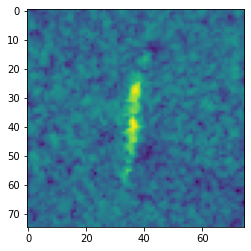

real: 0 predicted: [1.]


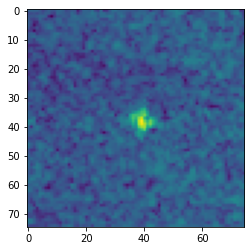

real: 1 predicted: [0.]


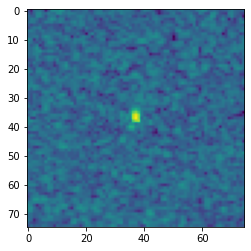

real: 1 predicted: [0.]


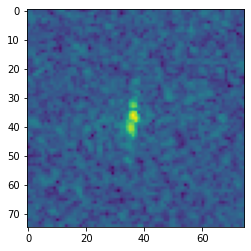

real: 1 predicted: [0.]


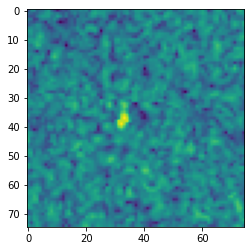

real: 1 predicted: [0.]


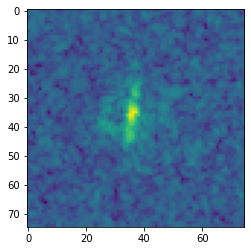

real: 1 predicted: [0.]


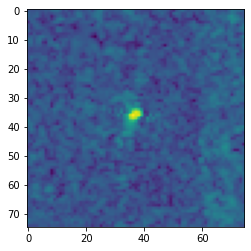

13

In [16]:
#前100组数据中预测错误的次数
pred = np.round(gmodel.predict(X_valid[0:100,:,:,:]))
num = 0;
for i in range(100):
    if  y_valid[i] !=  pred[i]:
        print('real:', y_valid[i], 'predicted:', pred[i])
        plt.imshow(X_valid[i,:,:,0])
        plt.show()
        num=num+1;
num

real: 0 predicted: [0.]


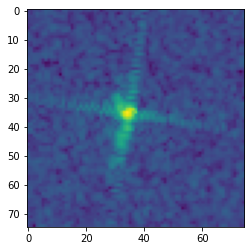

real: 0 predicted: [0.]


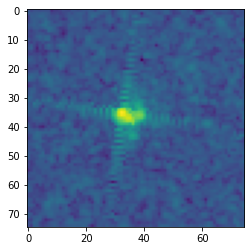

real: 1 predicted: [1.]


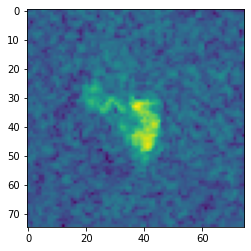

real: 0 predicted: [0.]


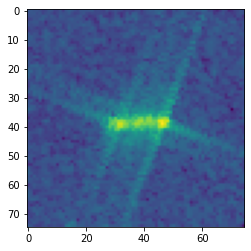

real: 1 predicted: [1.]


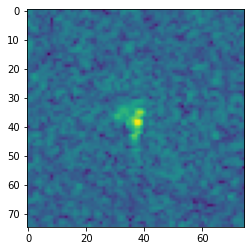

real: 0 predicted: [0.]


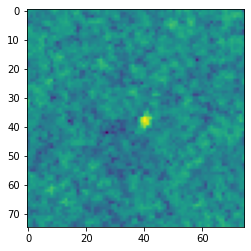

real: 0 predicted: [0.]


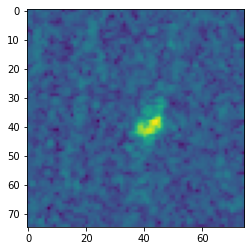

real: 1 predicted: [1.]


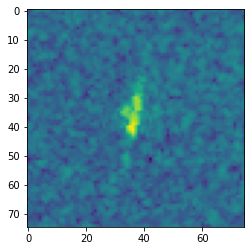

real: 1 predicted: [1.]


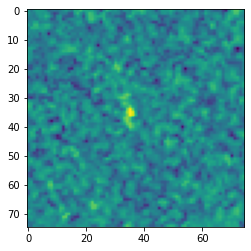

In [17]:
for i in range(10):
    if  y_valid[i] ==  pred[i]:
        print('real:', y_valid[i], 'predicted:', pred[i])
        plt.imshow(X_valid[i,:,:,0])
        plt.show()

In [18]:
gmodel=getModel()
gmodel.load_weights(filepath=file_path)

test = pd.read_json("D:/software/statoil-iceberg-classifier-challenge/test.json")
X_test = process1_data(test, predict=True)
#X_test = process_data(test, False)
predicted_test=gmodel.predict(X_test)

submission = pd.DataFrame()
submission['id'] = test['id']
submission['is_iceberg'] = predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('submission54.csv', index=False)

del test
del X_test
                            

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 73, 73, 128)       3584      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 36, 36, 128)       0         
                                                                 
 conv2d_5 (Conv2D)           (None, 34, 34, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 17, 17, 128)      0         
 2D)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 17, 17, 128)      